# Building off of the correlations we tested between metrics, this time we test them between DC schemes

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, DC_COLOR_MAPPINGS
from cli import get_file_paths

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh
import plotting
import pipeline

In [4]:
type_key = 'lf_'
site_key = "Carp"
# cycle_lengths = [1800, 720, 600, 360, 180, 60, 30, 6]
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

In [5]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = type_key.split('_')[0].upper()
if type_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '

In [6]:
pipeline_params = dict()
pipeline_params["read_csv"] = True
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = False
pipeline_params["show_PST"] = True
pipeline_params

{'read_csv': True,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'show_plots': False,
 'show_PST': True}

In [7]:
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["freq_tags"] = FREQ_GROUPS[type_key]
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'
data_params

{'site_name': 'Carp Pond',
 'site_tag': 'Carp',
 'type_tag': 'lf_',
 'freq_tags': [13000, 43000],
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '1800of1800',
 'resolution_in_min': '30',
 'recording_start': '02:00',
 'recording_end': '13:30'}

In [8]:
file_paths = get_file_paths(data_params)
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'bd2_TYPE_SITE_YEAR': 'bd2__lf_Carp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_lf_Carp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_lf_Carp_summary',
 'simulated_schemes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled/simulated_schemes',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LF_Carp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LF_Carp',
 'activity_bout_comparisons_figname': 'activity_bout_comparisons_per_dc_LF_Carp',
 'dc_bout_comparisons_figname': 'dc_bout_comparisons_per_night_LF

In [9]:
activity_dets_arr = pipeline.run_for_dets(data_params, pipeline_params, file_paths)
activity_bouts_arr = pipeline.run_for_bouts(data_params, pipeline_params, file_paths)

In [10]:
def plot_correlation_metrics(continuous_activity_df, adjusted_dc_df, fig_details):
    mean_number = continuous_activity_df.mean(axis=0)
    max_number = continuous_activity_df.max(axis=0)
    median_number = continuous_activity_df.median(axis=0)

    spearman_coeffs = continuous_activity_df.corrwith(adjusted_dc_df, method='spearman', axis=0)
    pearson_coeffs = continuous_activity_df.corrwith(adjusted_dc_df, method='pearson', axis=0)

    plt.figure(figsize=(15, 10))

    plt.rcParams.update({'font.size':16})
    plt.subplot(211)
    plt.title(f'Mean/Max/Median {fig_details["metric_name"]} per night for {fig_details["freq_group"]}calls in {fig_details["site_name"]}')
    plt.plot(max_number, color='brown', alpha=0.8, marker='.', label='Max # of calls per night')
    plt.plot(mean_number, color='navy', alpha=0.8, marker='.', label='Mean # of calls per night')
    plt.plot(median_number, color='blue', alpha=0.8, marker='.', label='Median # of calls per night')
    plt.grid(which='both')
    plot_xticks = [''] * len(continuous_activity_df.columns)
    plot_xticks[::2] = continuous_activity_df.columns[::2]
    plt.yscale('log')
    plt.xticks(continuous_activity_df.columns, plot_xticks, rotation=45)
    plt.xlim(0, len(continuous_activity_df.columns)-1)
    plt.legend(loc='upper right')

    plt.subplot(212)
    plt.title(f'Correlation coefficients between continuous and DC scheme: {fig_details["dc_tag"]}')
    plt.plot(spearman_coeffs, color='green', alpha=0.8, marker='.', label='Spearman coefficients')
    plt.plot(pearson_coeffs, color='orange', alpha=0.8, marker='.', label='Pearson coefficients')
    plt.grid(which='both')
    plot_xticks = [''] * len(continuous_activity_df.columns)
    plot_xticks[::2] = continuous_activity_df.columns[::2]
    plt.xticks(continuous_activity_df.columns, plot_xticks, rotation=45)
    plt.xlim(0, len(continuous_activity_df.columns)-1)
    plt.ylim(0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_spearman_correlation_metrics_bouts_dc(activity_arr, data_params):

    continuous_activity_df = dh.construct_activity_grid_for_bouts(activity_arr, '1800of1800')

    mean_number = continuous_activity_df.mean(axis=0)
    max_number = continuous_activity_df.max(axis=0)
    median_number = continuous_activity_df.median(axis=0)

    plt.figure(figsize=(15, 14))

    plt.rcParams.update({'font.size':16})
    plt.subplot(211)
    plt.title(f'Mean/Max/Median {fig_details["metric_name"]} per night for {fig_details["freq_group"]}calls in {fig_details["site_name"]}')
    plt.plot(max_number, color='brown', alpha=0.8, marker='.', label='Max # of calls per night')
    plt.plot(mean_number, color='navy', alpha=0.8, marker='.', label='Mean # of calls per night')
    plt.plot(median_number, color='blue', alpha=0.8, marker='.', label='Median # of calls per night')
    plt.grid(which='both')
    plot_xticks = [''] * len(continuous_activity_df.columns)
    plot_xticks[::2] = continuous_activity_df.columns[::2]
    plt.yscale('log')
    plt.xticks(continuous_activity_df.columns, plot_xticks, rotation=45)
    plt.xlim(0, len(continuous_activity_df.columns)-1)
    plt.legend(loc='upper right')


    plt.subplot(212)
    plt.title(f'Spearman correlation coefficients for DC schemes')

    for dc_tag in data_params['dc_tags']:
        dc_activity_bouts_df = dh.construct_activity_grid_for_bouts(activity_arr, dc_tag)
        on = int(dc_tag.split('of')[0])
        total = int(dc_tag.split('of')[1])
        recover_ratio = total / on
        adjusted_dc_df = recover_ratio*dc_activity_bouts_df

        fig_details['dc_tag'] = dc_tag
        spearman_coeffs = continuous_activity_df.corrwith(adjusted_dc_df, method='spearman', axis=0)
        score = spearman_coeffs.mean(axis=0)
        plt.plot(spearman_coeffs, color=DC_COLOR_MAPPINGS[dc_tag], alpha=0.8, marker='.', label=f'{dc_tag} (score={round(score, 2)})')

    plt.grid(which='both')
    plot_xticks = [''] * len(continuous_activity_df.columns)
    plot_xticks[::2] = continuous_activity_df.columns[::2]
    plt.xticks(continuous_activity_df.columns, plot_xticks, rotation=45)
    plt.xlim(0, len(continuous_activity_df.columns)-1)
    plt.ylim(0, 1.1)
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()


def plot_spearman_correlation_metrics_dets_dc(activity_arr, data_params):

    continuous_activity_df = dh.construct_activity_grid_for_number_of_dets(activity_arr, '1800of1800')

    mean_number = continuous_activity_df.mean(axis=0)
    max_number = continuous_activity_df.max(axis=0)
    median_number = continuous_activity_df.median(axis=0)

    plt.figure(figsize=(15, 14))

    plt.rcParams.update({'font.size':16})
    plt.subplot(211)
    plt.title(f'Mean/Max/Median {fig_details["metric_name"]} per night for {fig_details["freq_group"]}calls in {fig_details["site_name"]}')
    plt.plot(max_number, color='brown', alpha=0.8, marker='.', label='Max # of calls per night')
    plt.plot(mean_number, color='navy', alpha=0.8, marker='.', label='Mean # of calls per night')
    plt.plot(median_number, color='blue', alpha=0.8, marker='.', label='Median # of calls per night')
    plt.grid(which='both')
    plot_xticks = [''] * len(continuous_activity_df.columns)
    plot_xticks[::2] = continuous_activity_df.columns[::2]
    plt.yscale('log')
    plt.xticks(continuous_activity_df.columns, plot_xticks, rotation=45)
    plt.xlim(0, len(continuous_activity_df.columns)-1)
    plt.legend(loc='upper right')


    plt.subplot(212)
    plt.title(f'Spearman correlation coefficients for DC schemes')

    for dc_tag in data_params['dc_tags']:
        dc_activity_bouts_df = dh.construct_activity_grid_for_number_of_dets(activity_arr, dc_tag)
        on = int(dc_tag.split('of')[0])
        total = int(dc_tag.split('of')[1])
        recover_ratio = total / on
        adjusted_dc_df = recover_ratio*dc_activity_bouts_df

        fig_details['dc_tag'] = dc_tag
        spearman_coeffs = continuous_activity_df.corrwith(adjusted_dc_df, method='spearman', axis=0)
        score = spearman_coeffs.mean(axis=0)
        plt.plot(spearman_coeffs, color=DC_COLOR_MAPPINGS[dc_tag], alpha=0.8, marker='.', label=f'{dc_tag} (score={round(score, 2)})')

    plt.grid(which='both')
    plot_xticks = [''] * len(continuous_activity_df.columns)
    plot_xticks[::2] = continuous_activity_df.columns[::2]
    plt.xticks(continuous_activity_df.columns, plot_xticks, rotation=45)
    plt.xlim(0, len(continuous_activity_df.columns)-1)
    plt.ylim(0, 1.1)
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

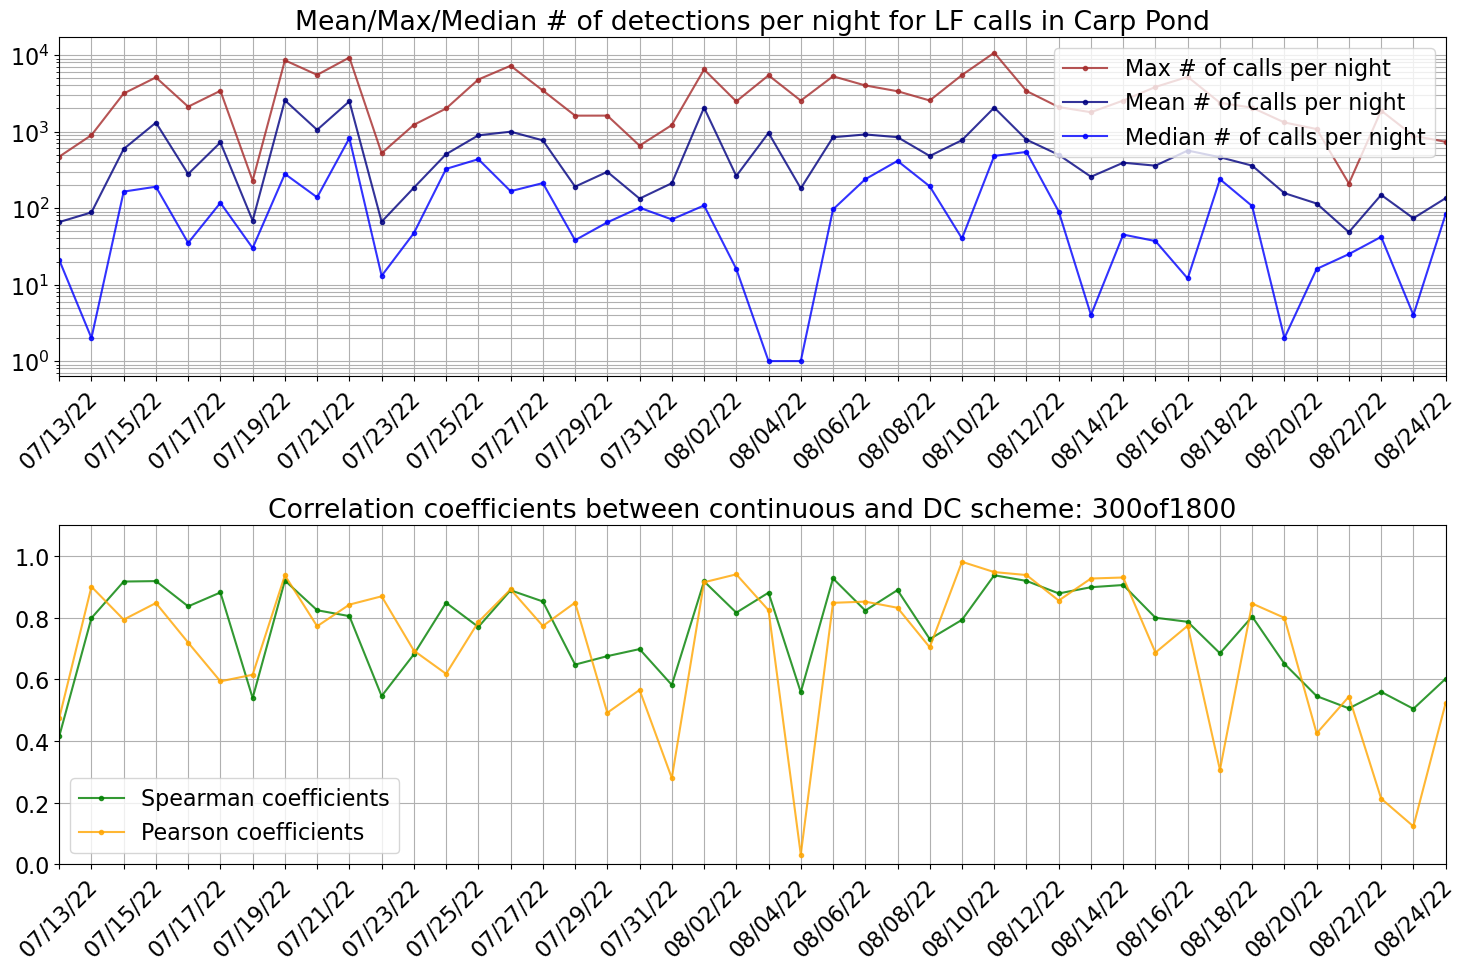

In [11]:
continuous_activity_df = dh.construct_activity_grid_for_number_of_dets(activity_dets_arr, '1800of1800')

dc_tag = '300of1800'
dc_activity_dets_df = dh.construct_activity_grid_for_number_of_dets(activity_dets_arr, dc_tag)
on = int(dc_tag.split('of')[0])
total = int(dc_tag.split('of')[1])
recover_ratio = total / on
adjusted_dc_dets_df = recover_ratio*dc_activity_dets_df
adjusted_dc_df = adjusted_dc_dets_df

fig_details['metric_name'] = '# of detections'
fig_details['dc_tag'] = dc_tag

mean_number = continuous_activity_df.mean(axis=0)
max_number = continuous_activity_df.max(axis=0)
median_number = continuous_activity_df.median(axis=0)

spearman_coeffs = continuous_activity_df.corrwith(adjusted_dc_df, method='spearman', axis=0)
pearson_coeffs = continuous_activity_df.corrwith(adjusted_dc_df, method='pearson', axis=0)

plot_correlation_metrics(continuous_activity_df, adjusted_dc_dets_df, fig_details)

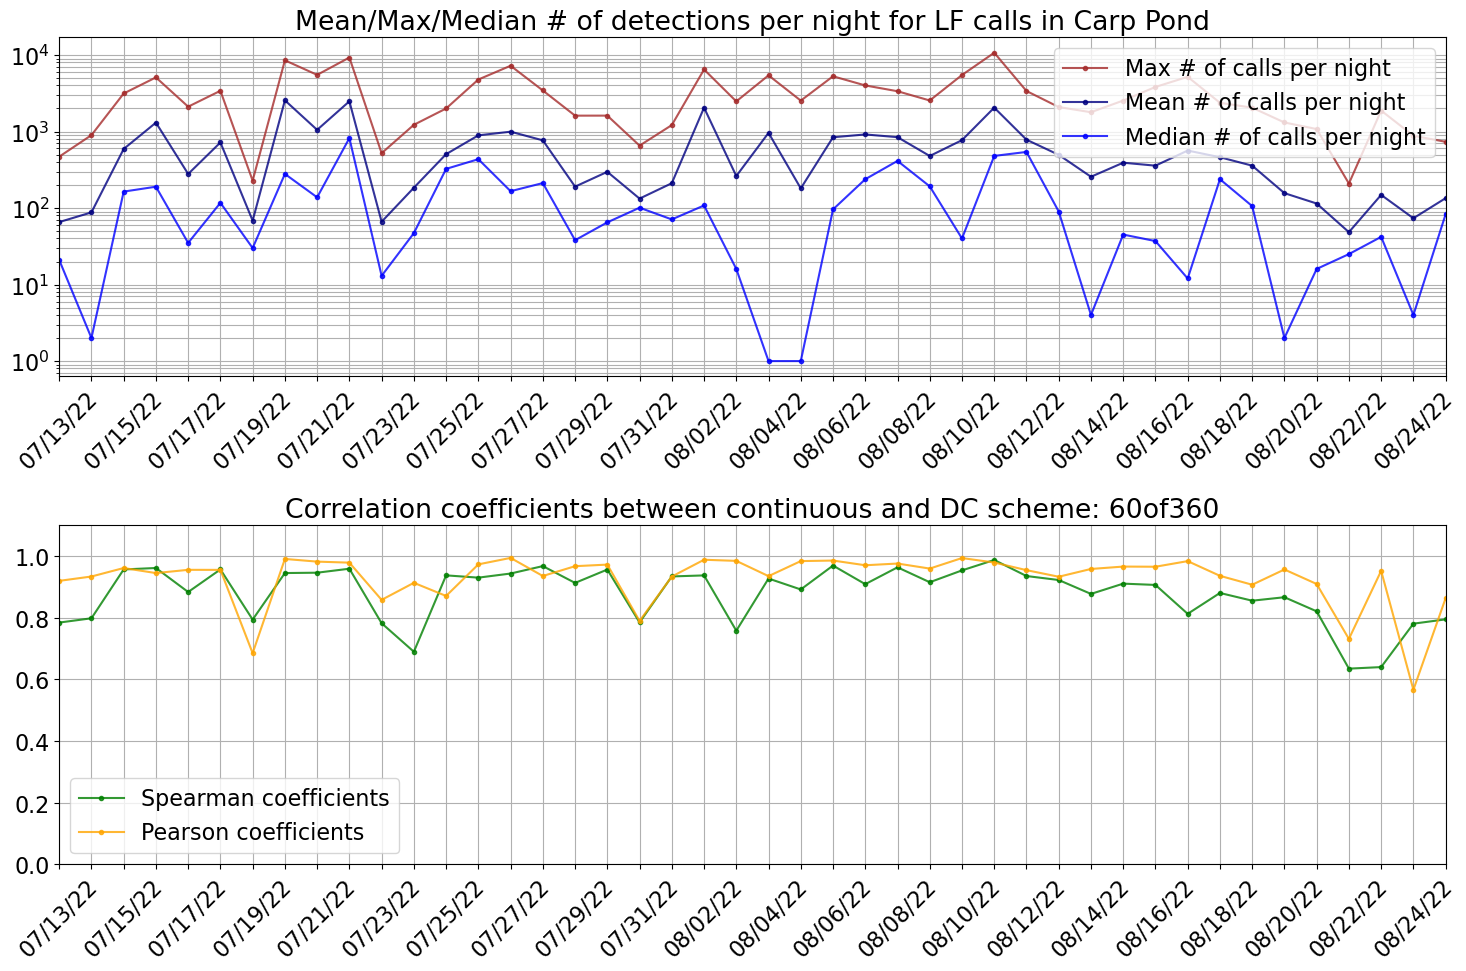

In [12]:
continuous_activity_df = dh.construct_activity_grid_for_number_of_dets(activity_dets_arr, '1800of1800')

dc_tag = '60of360'
dc_activity_dets_df = dh.construct_activity_grid_for_number_of_dets(activity_dets_arr, dc_tag)
on = int(dc_tag.split('of')[0])
total = int(dc_tag.split('of')[1])
recover_ratio = total / on
adjusted_dc_dets_df = recover_ratio*dc_activity_dets_df

fig_details['dc_tag'] = dc_tag

plot_correlation_metrics(continuous_activity_df, adjusted_dc_dets_df, fig_details)

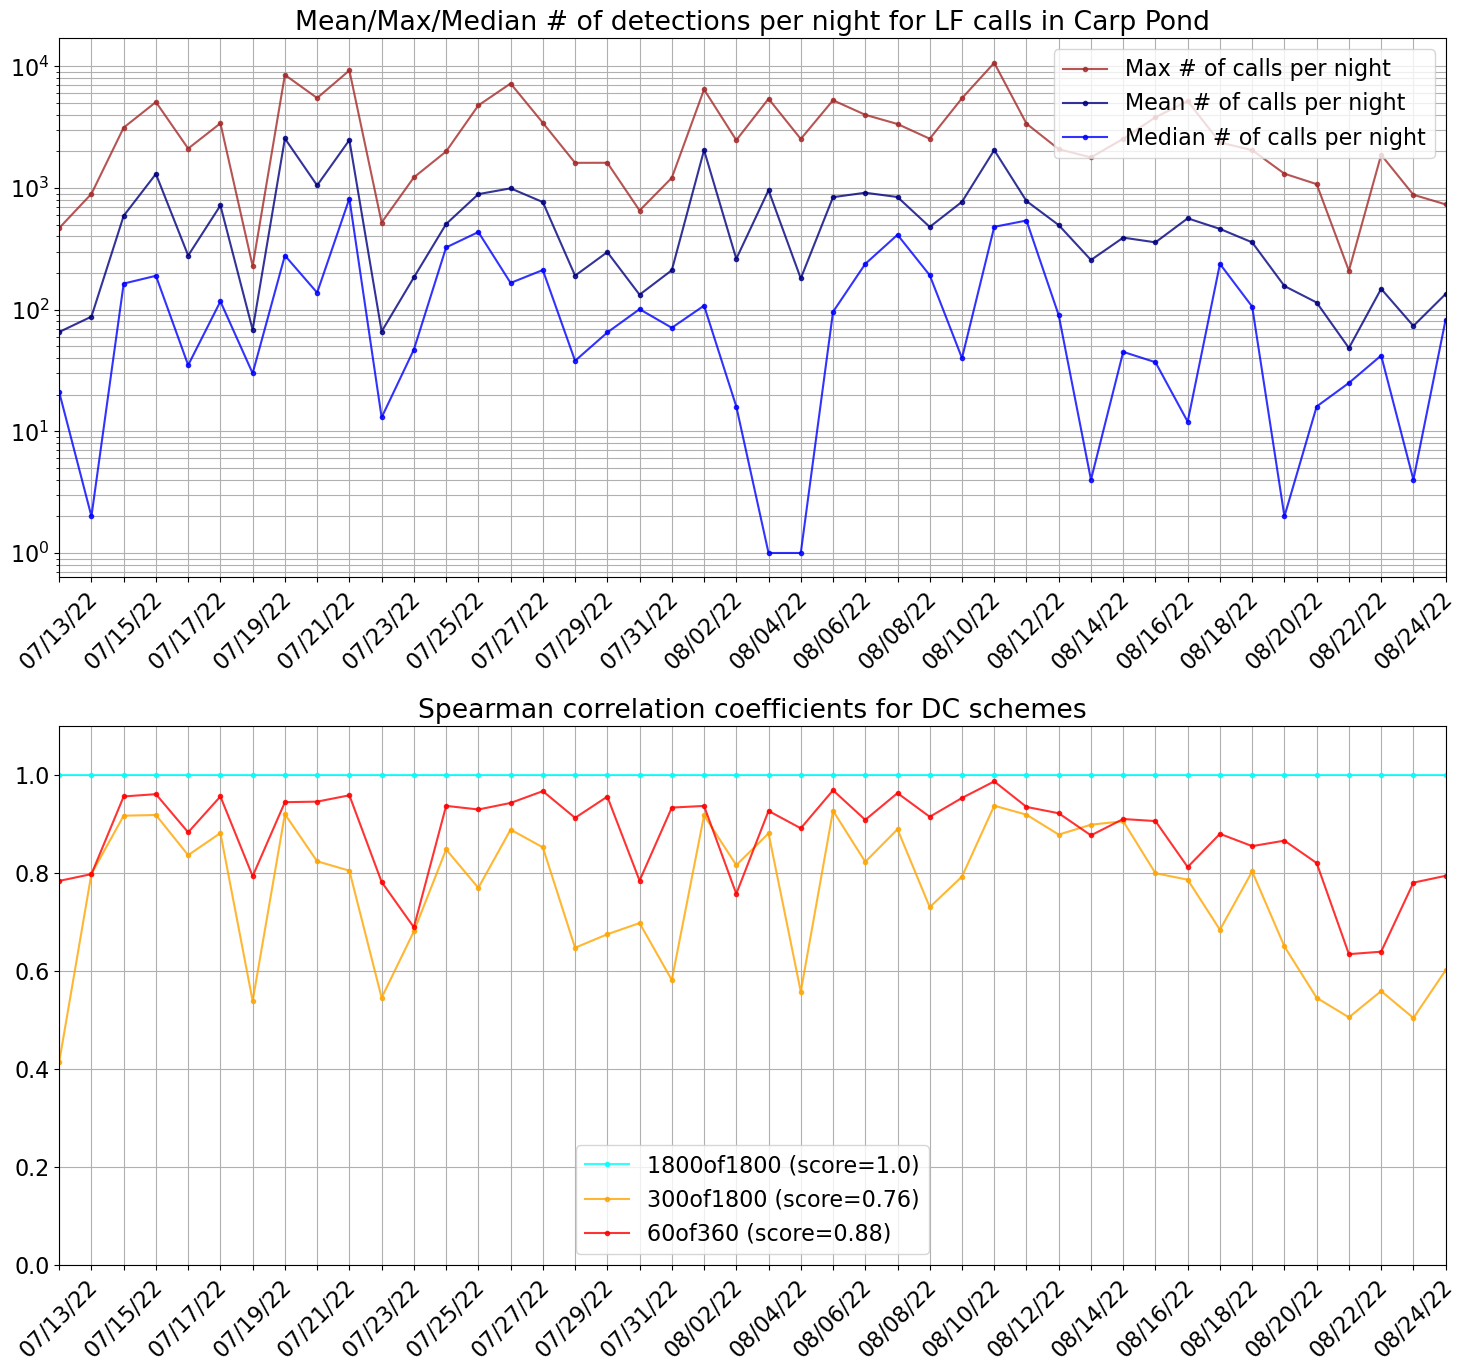

In [13]:
plot_spearman_correlation_metrics_dets_dc(activity_dets_arr, data_params)

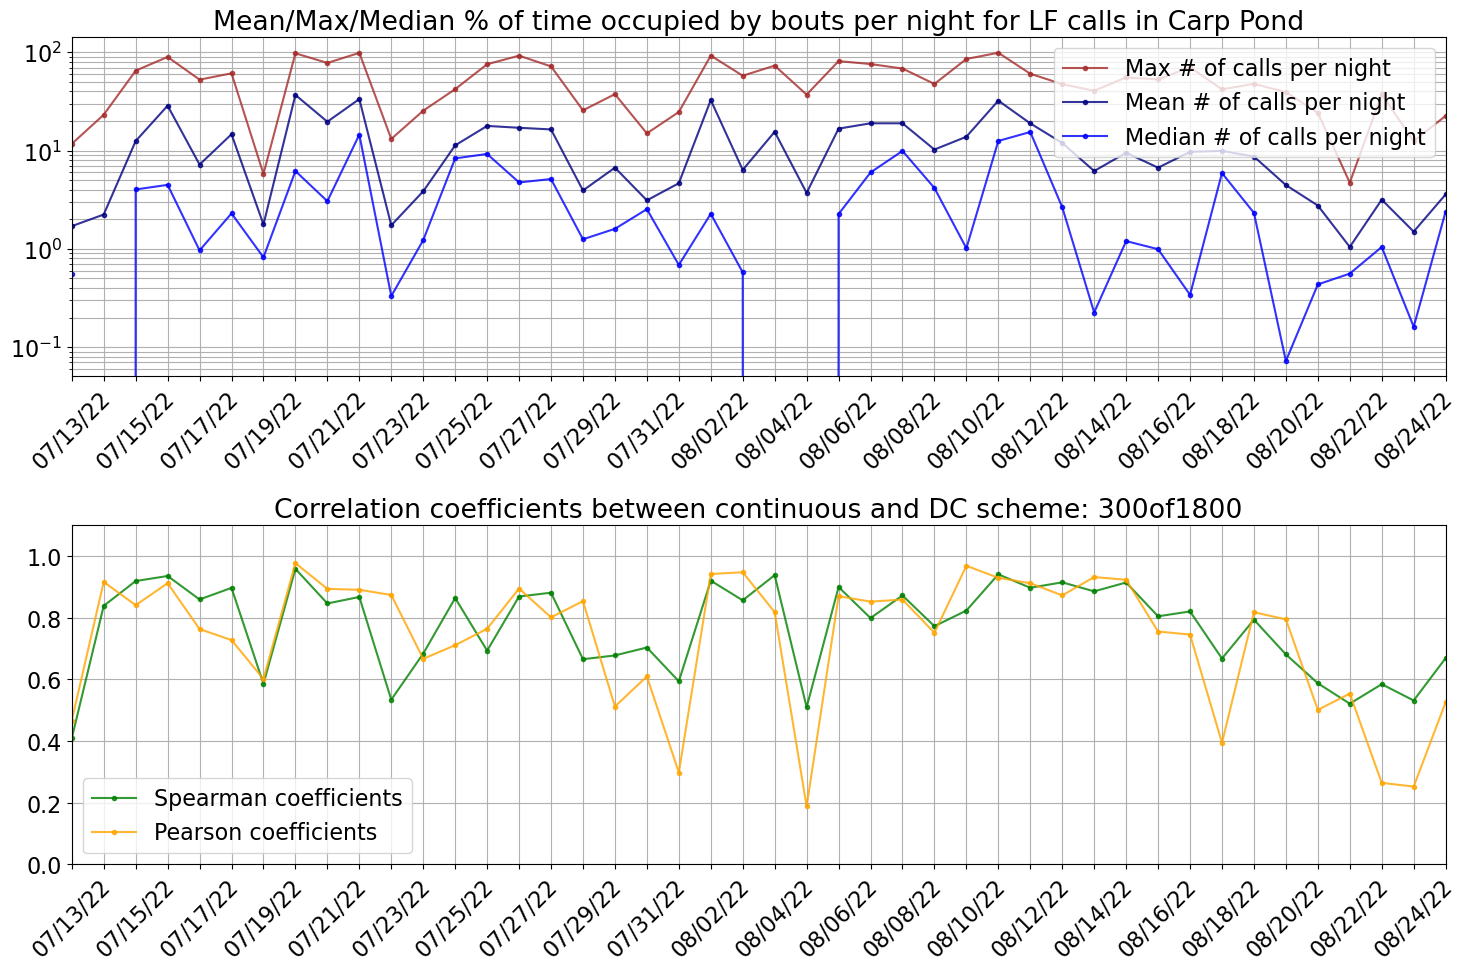

In [14]:
continuous_activity_bouts_df = dh.construct_activity_grid_for_bouts(activity_bouts_arr, '1800of1800')

dc_tag = '300of1800'
dc_activity_bouts_df = dh.construct_activity_grid_for_bouts(activity_bouts_arr, dc_tag)
on = int(dc_tag.split('of')[0])
total = int(dc_tag.split('of')[1])
recover_ratio = total / on
adjusted_dc_bouts_df = recover_ratio*dc_activity_bouts_df

fig_details['metric_name'] = '% of time occupied by bouts'
fig_details['dc_tag'] = dc_tag

plot_correlation_metrics(continuous_activity_bouts_df, adjusted_dc_bouts_df, fig_details)

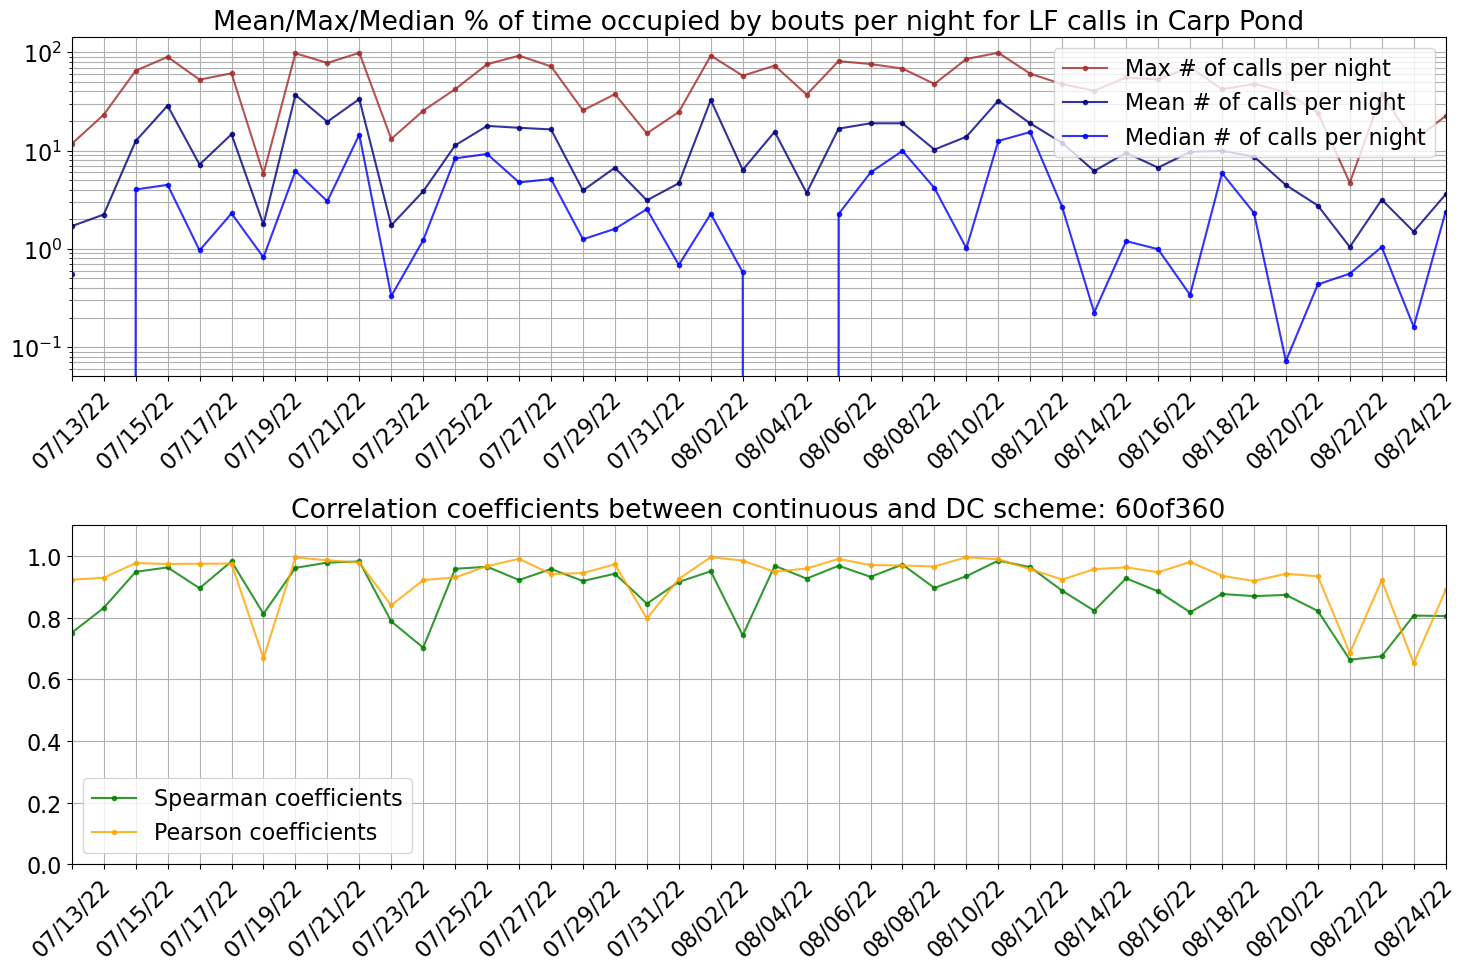

In [15]:
continuous_activity_bouts_df = dh.construct_activity_grid_for_bouts(activity_bouts_arr, '1800of1800')

dc_tag = '60of360'
dc_activity_bouts_df = dh.construct_activity_grid_for_bouts(activity_bouts_arr, dc_tag)
on = int(dc_tag.split('of')[0])
total = int(dc_tag.split('of')[1])
recover_ratio = total / on
adjusted_dc_bouts_df = recover_ratio*dc_activity_bouts_df

fig_details['dc_tag'] = dc_tag

plot_correlation_metrics(continuous_activity_bouts_df, adjusted_dc_bouts_df, fig_details)

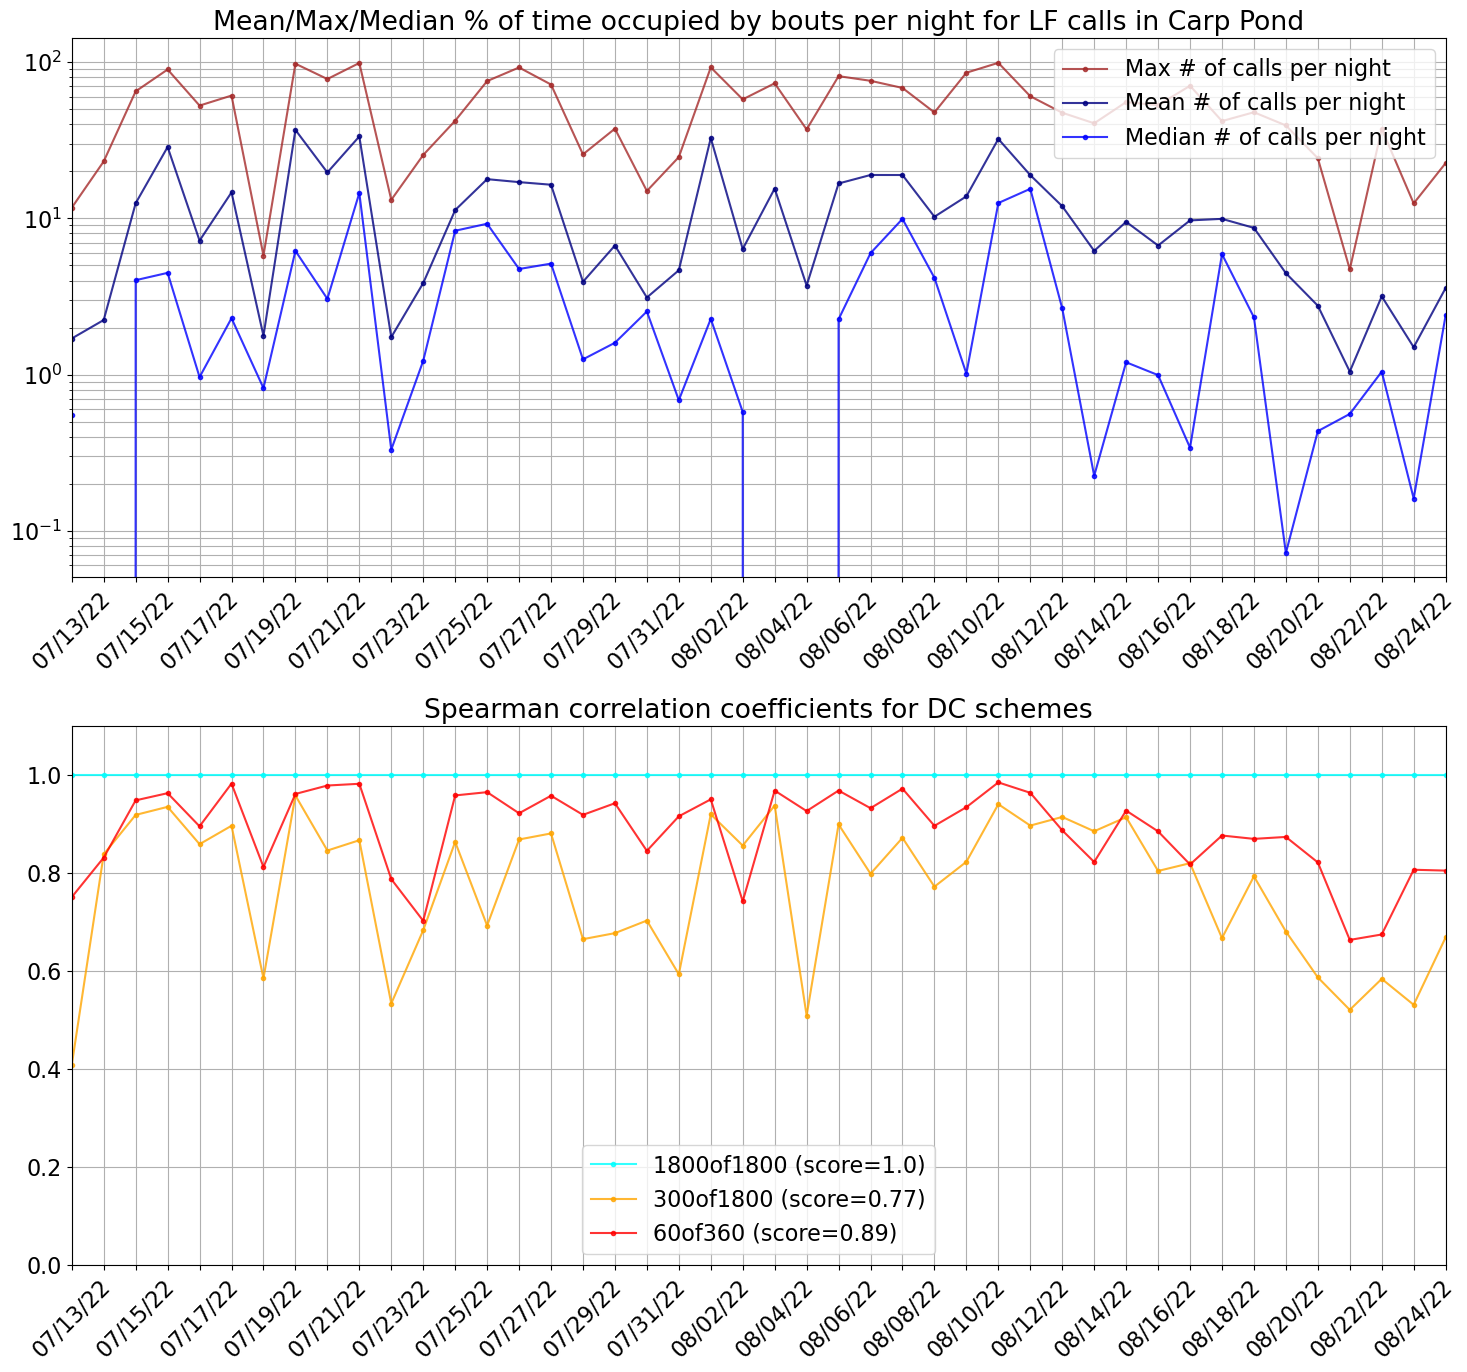

In [16]:
plot_spearman_correlation_metrics_bouts_dc(activity_bouts_arr, data_params)